In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

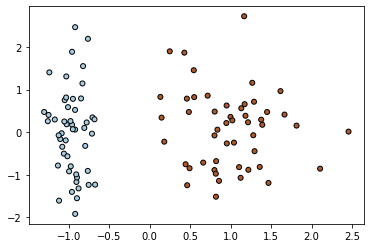

In [2]:
X, Y = make_classification(n_features=2, n_redundant=0, n_informative=1,
                             n_clusters_per_class=1, random_state=42)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k', cmap=plt.cm.Paired)

### IRLS_MAP

In [3]:
def logistic_function(a):
    return 1/(1+np.exp(-1*a))

def R(x,w):
    prediction = logistic_function(x.dot(w))
    return np.diag(np.multiply(prediction, (1-prediction)).ravel())

def A(x,w,S_inv):
    r = R(x,w)
    return x.T.dot(r).dot(x) + S_inv

def IRLS_map(x,y, m, S, tol=1e-3, maxiter=100):
    w = np.zeros(x.shape[1]).reshape(-1,1)
    previous_w = None
    i = 0
    S_inv = np.linalg.inv(S)
    m = m.reshape(-1,1)
    y = y.reshape(-1,1)
    
    while i < maxiter and (previous_w is None or not all(np.isclose(w,previous_w, rtol=tol))):
        previous_w = np.copy(w)
        a = A(x,w,S_inv)
        prediction = logistic_function(x.dot(w))
        
        aux = x.T.dot(y-prediction) - S_inv.dot(w - m)
        
        w = w + np.linalg.inv(a).dot(aux)
        i += 1

    return w.ravel()

def posteriori(x,y, m, S):
    w_hat = IRLS_map(x,y,m,S)
    
    S_inv = np.linalg.inv(S)
    r_hat = R(x,w_hat)
    H = x.T.dot(r_hat).dot(x) + S_inv
    
    return w_hat, np.linalg.inv(H)

In [4]:
mean_0 = np.array([0,0])
var_0 = np.array([
    [1,0],
    [0,1]
])
mean, var = posteriori(X,Y,mean_0, var_0)
mean, var

(array([3.48830574, 0.19907485]),
 array([[0.27499015, 0.01616747],
        [0.01616747, 0.17249295]]))

In [5]:
monte_carlo_models = np.random.multivariate_normal(mean.ravel(), var, 5).T
def predict_monte_carlo(x, m, S):
    y = np.sum(logistic_function(x.dot(monte_carlo_models)), axis=1)    
    return y/monte_carlo_models.shape[1]

def predict_probit(x, m, S):

    m_a = x.dot(m)
    sigma_a = x.dot(S).dot(x.T)
    
    y = logistic_function(np.sqrt(1 + np.pi*sigma_a/8).dot(m_a))
    
    return y


In [6]:
def isolated_prediction(X,mean,S, approximation_function):
    y = []
    for x in X:
        y.append(approximation_function(x.reshape(1,-1),mean,var))
        
    return np.array(y).ravel()

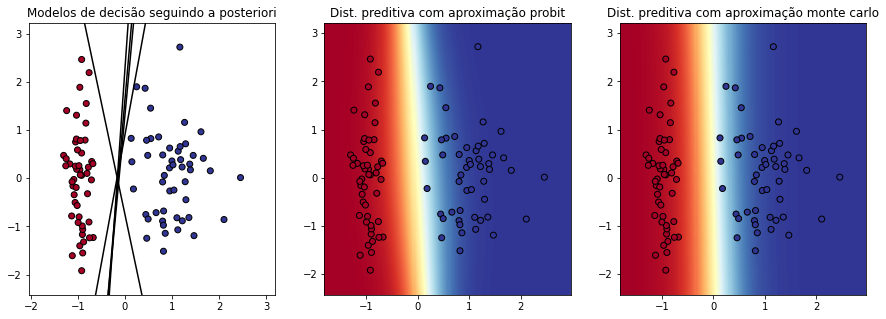

In [7]:
margin = 0.5
cmap = plt.cm.RdYlBu
x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

models_samples = np.random.multivariate_normal(mean.ravel(), var, 5) # como w segue uma distribuição normal, os modelos gerados aleatoriamente seguind oessa distruibuição representam bem os dados

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for w in models_samples:
    y = (w[0] * xx[0])/w[1] + 0.5/w[1]
    plt.plot(xx[0],y, "k-")
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=cmap)
plt.ylim(y_min, y_max)
plt.title("Modelos de decisão seguindo a posteriori")

Z_probit = isolated_prediction(np.c_[xx.ravel(), yy.ravel()], mean, var, predict_probit).reshape(xx.shape)
plt.subplot(1,3,2)
plt.pcolormesh(xx, yy, Z_probit, cmap=cmap, shading="auto")
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=cmap)
_ = plt.title("Dist. preditiva com aproximação probit")

Z_monte_carlo = isolated_prediction(np.c_[xx.ravel(), yy.ravel()], mean, var, predict_monte_carlo).reshape(xx.shape)
plt.subplot(1,3,3)
plt.pcolormesh(xx, yy, Z_monte_carlo, cmap=cmap, shading="auto")
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=cmap)
_ = plt.title("Dist. preditiva com aproximação monte carlo")